In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
import tensorflow as tf
from keras import Model
from scipy.integrate import odeint
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Fisher Traveling wave soludion 
def vec_direction(eps,V):
    A = np.array(([eps*V, 1],[1,V]))/(1-eps*V**2)
    w, v = LA.eig(A)
    return v[:,1]

def dU_dx(U, x,eps,V):
    # Here U is a vector such that y=U[0] and z=U[1]. This function should return [y', z']
    return [U[1], ((1- eps*(1-3*U[0]+1.5*U[0]*U[0])) * V *U[1] + U[0]* (1-U[0])* (1-0.5*U[0]))/(eps*V**2-1)]

In [ ]:
def data_c(c_li, modi_r, p_am):
    tiny = 1E-6
    train_raw = []
    target_c,target_eps = [],[]
    for c in c_li:
        eps_temp = np.linspace(0, 1/c**2*0.99,20)
        for eps in eps_temp:
            target_c.append(c)
            target_eps.append(eps)
            vec_1 = vec_direction(eps,c)
            U0 = [1+tiny*vec_1[0], tiny*vec_1[1]]
            ts = np.linspace(0, 500, p_am)
            Us = odeint(dU_dx, U0, ts, args=(eps, c))
            ys = Us[:,0]
            u_range = np.linspace(0.05, 0.95, 11)
            u_one = []
            for u_r in u_range:
                # Two different graph on this range and add noise!
                specific_range = np.where(np.logical_and(ys>=u_r-modi_r, ys<=u_r+modi_r))
                specific_t_range = ts[specific_range]
                u_one.append(np.mean(specific_t_range))
            train_raw.append(u_one)
    
    train_data = np.array(train_raw)
    train_set = train_data[:,:-1] - train_data[:,1:]
    data_pd = pd.DataFrame(data=train_set)
    data_pd['target_c'] = target_c
    data_pd['target_eps'] = target_eps
    return data_pd

def data_eps(c, modi_r, p_am):
    tiny = 1E-6
    train_raw = []
    target_c,target_eps = [],[]
    c_li = [c]
    for c in c_li:
        eps_temp = np.linspace(0, 1/c**2*0.99,200)
        for eps in eps_temp:
            target_eps.append(eps)
            vec_1 = vec_direction(eps,c)
            U0 = [1+tiny*vec_1[0], tiny*vec_1[1]]
            ts = np.linspace(0, 500, p_am)
            Us = odeint(dU_dx, U0, ts, args=(eps, c))
            ys = Us[:,0]
            u_range = np.linspace(0.05, 0.95, 11)
            u_one = []
            for u_r in u_range:
                # Two different graph on this range and add noise!
                specific_range = np.where(np.logical_and(ys>=u_r-modi_r, ys<=u_r+modi_r))
                specific_t_range = ts[specific_range]
                u_one.append(np.mean(specific_t_range))
            train_raw.append(u_one)
    
    train_data = np.array(train_raw)
    train_set = train_data[:,:-1] - train_data[:,1:]
    data_pd = pd.DataFrame(data=train_set)
    data_pd['target_eps'] = target_eps
    return data_pd

In [ ]:
# LinearRegression positive=True, it force coef be positive, but intercept can be negative
classifiers = [
    linear_model.BayesianRidge(),
    linear_model.Ridge(alpha=.1),
    linear_model.Lasso(alpha=0.005,positive=True),
    linear_model.ARDRegression(),
    linear_model.SGDRegressor(),
    linear_model.LinearRegression(),
    linear_model.LinearRegression(positive=True)]

In [ ]:
v_li = np.linspace(2,10,201)
data = data_c(v_li, 0.001, 25000)
v_dat = data.iloc[:,:-1]

In [ ]:
train_data = v_dat.drop('target_c', axis=1)
target_data = v_dat['target_c']
X_train, X_test, y_train, y_test = train_test_split(
            train_data, target_data, test_size=0.9, random_state=42)

In [ ]:
# Linear model (Cross validation score)
for clf in classifiers:
    pipe_c = Pipeline([('transformer', MinMaxScaler()), ('estimator', clf)])
    scores_c = cross_val_score(pipe_c, X_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error')
    pipe_c.fit(X_train, y_train)
    y_pred = pipe_c.predict(X_test)
    y_all = pipe_c.predict(train_data)

In [ ]:
ens_train = []
ens_test = []
ens_all_pred = []
for clf in classifiers:
    pipe_c = Pipeline([('transformer', MinMaxScaler()), ('estimator', clf)])
    pipe_c.fit(X_train, y_train)
    y_pred = pipe_c.predict(X_train)
    y_pred_test = pipe_c.predict(X_test)
    ens_train.append(y_pred.tolist())
    ens_test.append(y_pred_test.tolist())
    y_all = pipe_c.predict(train_data)
    ens_all_pred.append(y_all.tolist())

ens_train = np.array(ens_train).transpose()
ens_test = np.array(ens_test).transpose()
ens_all_pred = np.array(ens_all_pred).transpose()

In [ ]:
# Ensemble method
lin = linear_model.LinearRegression()
pipe_v = Pipeline([('transformer', MinMaxScaler()), ('estimator', lin)])
pipe_v.fit(ens_train, y_train)
ens_pred = pipe_v.predict(ens_test)
all_pred = pipe_v.predict(ens_all_pred)

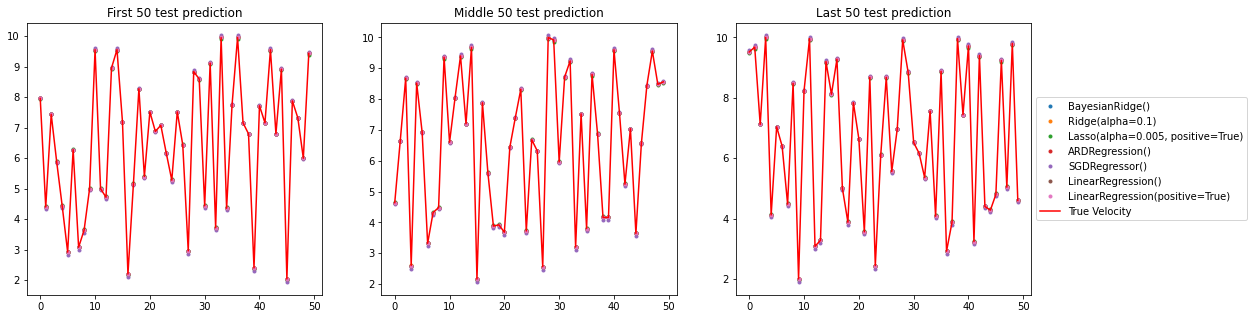

In [ ]:
figure, axis = plt.subplots(1, 3,figsize=(18, 5))
mid_v = int(len(ens_test)/2)

for i in range(len(classifiers)):
    axis[0].plot(ens_test[:50,i],'.',label=classifiers[i])
    axis[1].plot(ens_test[mid_v:(mid_v+50),i],'.',label=classifiers[i])
    axis[2].plot(ens_test[-50:,i],'.',label=classifiers[i])
    
axis[0].plot(y_test.to_numpy()[:50],'r', label='True Velocity')
axis[1].plot(y_test.to_numpy()[mid_v:(mid_v+50)],'r', label='True Velocity')
axis[2].plot(y_test.to_numpy()[-50:],'r', label='True Velocity')

axis[0].set_title('First 50 test prediction')
axis[1].set_title('Middle 50 test prediction')
axis[2].set_title('Last 50 test prediction')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Epsilon prediction 

In [ ]:
eps_d = data_eps(2.5, 0.001, 25000)
data_pred_eps = eps_d

In [ ]:
classifiers = [
    linear_model.BayesianRidge(),
    linear_model.Ridge(alpha=.1),
    linear_model.Lasso(alpha=0.01),
    linear_model.ARDRegression(),
    linear_model.SGDRegressor(),
    linear_model.LinearRegression(),
    linear_model.LinearRegression(positive=True)]

In [ ]:
train_data = eps_d.drop('target_eps', axis=1).to_numpy()
target_data = eps_d['target_eps'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
            train_data, target_data, test_size=0.1, random_state=42)

In [ ]:
for clf in classifiers:
    pipe_c = Pipeline([('transformer', MinMaxScaler()), ('estimator', clf)])
    scores_c = cross_val_score(pipe_c, X_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error')
    pipe_c.fit(X_train, y_train)
    y_pred = pipe_c.predict(X_test)
    y_all = pipe_c.predict(train_data)

In [ ]:
ens_train = []
ens_test = []
ens_all_pred = []
for clf in classifiers:
    pipe_c = Pipeline([('transformer', MinMaxScaler()), ('estimator', clf)])
    pipe_c.fit(X_train, y_train)
    y_pred = pipe_c.predict(X_train)
    y_pred_test = pipe_c.predict(X_test)
    ens_train.append(y_pred.tolist())
    ens_test.append(y_pred_test.tolist())
    y_all = pipe_c.predict(train_data)
    ens_all_pred.append(y_all.tolist())
ens_train = np.array(ens_train).transpose()
ens_test = np.array(ens_test).transpose()
ens_all_pred = np.array(ens_all_pred).transpose()

In [ ]:
X_sc = MinMaxScaler()
y_sc = MinMaxScaler()
X_sc.fit(train_data)
y_sc.fit(target_data.reshape(-1,1))

X_train = X_sc.transform(X_train)
y_train = y_sc.transform(y_train.reshape(-1,1))
X_test = X_sc.transform(X_test)
y_test = y_sc.transform(y_test.reshape(-1,1))

In [ ]:
def nn_eps_model(input_dimensional,opt):
    def bm():
        model = Sequential()
        model.add(Dense(units = 10, activation = 'linear', input_dim=input_dimensional))
        model.add(Dense(units = 20, activation = 'tanh'))
        model.add(Dense(units = 20, activation = 'tanh'))
        model.add(Dense(units = 1, activation = 'relu'))
        model.compile(optimizer = opt,loss = 'mean_squared_error')
        return model 
    return bm

In [ ]:
opt_eps = tf.keras.optimizers.Adam(learning_rate=0.005)

In [ ]:
%%capture test
neural_net = KerasRegressor(build_fn= nn_eps_model(10, opt_eps), 
                                    epochs=500,batch_size=20)
neural_net.fit(X_train, y_train)

y_pred_nn = neural_net.predict(X_test)
all_pred_nn = neural_net.predict(X_sc.transform(train_data))
train_pred_nn = neural_net.predict(X_sc.transform(X_train))

In [ ]:
def Rnn_model(opt, shape):
    def bm():
        model = Sequential()
        model.add(SimpleRNN(units = 10, activation = 'tanh', input_shape=(shape[1],shape[2])))
        model.add(Dense(units = 20, activation = 'tanh'))
        model.add(Dense(units = 20, activation = 'tanh'))
        model.add(Dense(units = 1, activation = 'relu'))
        model.compile(optimizer = opt,loss = 'mean_squared_error')
        return model 
    return bm

def Rnn_transform(data):
    return np.reshape(data, (data.shape[0], data.shape[1],1))

In [ ]:
X_train = Rnn_transform(X_train)
X_test = Rnn_transform(X_test)
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)
opt_eps = tf.keras.optimizers.Adam(learning_rate=0.005)

In [ ]:
%%capture test
Rnn_net = KerasRegressor(build_fn=Rnn_model(opt_eps,X_train.shape), epochs=500)

Rnn_net.fit(X_train, y_train)
y_pred_rnn = Rnn_net.predict(X_test)
all_pred_rnn = Rnn_net.predict(Rnn_transform(X_sc.transform(train_data)))
train_pred_rnn =Rnn_net.predict(X_train)

In [ ]:
ens_train = np.hstack((ens_train, y_sc.inverse_transform(train_pred_nn.reshape(-1,1))))
ens_test = np.hstack((ens_test, y_sc.inverse_transform(y_pred_nn.reshape(-1,1))))
ens_all_pred = np.hstack((ens_all_pred, y_sc.inverse_transform(all_pred_nn.reshape(-1,1))))

ens_train = np.hstack((ens_train, y_sc.inverse_transform(train_pred_rnn.reshape(-1,1))))
ens_test = np.hstack((ens_test, y_sc.inverse_transform(y_pred_rnn.reshape(-1,1))))
ens_all_pred = np.hstack((ens_all_pred, y_sc.inverse_transform(all_pred_rnn.reshape(-1,1))))

In [ ]:
# Ensemble method
ens = linear_model.LinearRegression()
pipe_c = Pipeline([('transformer', MinMaxScaler()), ('estimator', ens)])
ens_train_t = y_sc.inverse_transform(y_train.reshape(-1,1))
pipe_c.fit(ens_train,ens_train_t)
y_pred = pipe_c.predict(ens_test)
y_all = pipe_c.predict(ens_all_pred)

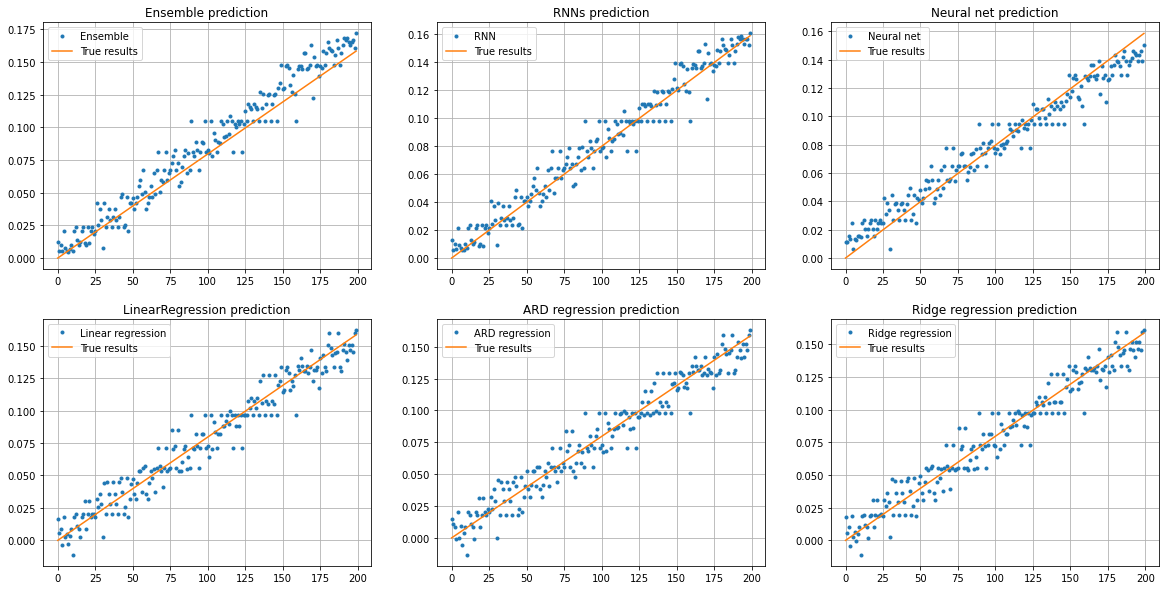

In [ ]:
figure, axis = plt.subplots(2, 3,figsize=(20, 10))
axis[0, 0].plot(y_all,'.', label='Ensemble')
axis[0, 0].plot(target_data, label='True results')
axis[0, 0].set_title("Ensemble prediction")
axis[0, 0].legend()
axis[0, 0].grid()

axis[0, 1].plot(ens_all_pred[:,-1],'.', label='RNN')
axis[0, 1].plot(target_data, label='True results')
axis[0, 1].set_title("RNNs prediction")
axis[0, 1].legend()
axis[0, 1].grid()

axis[0, 2].plot(ens_all_pred[:,-2],'.',label='Neural net')
axis[0, 2].plot(target_data, label='True results')
axis[0, 2].set_title("Neural net prediction")
axis[0, 2].legend()
axis[0, 2].grid()

axis[1, 0].plot(ens_all_pred[:,5],'.', label='Linear regression')
axis[1, 0].plot(target_data, label='True results')
axis[1, 0].set_title("LinearRegression prediction")
axis[1, 0].legend()
axis[1, 0].grid()

axis[1, 1].plot(ens_all_pred[:,3],'.',label='ARD regression')
axis[1, 1].plot(target_data, label='True results')
axis[1, 1].set_title("ARD regression prediction")
axis[1, 1].legend()
axis[1, 1].grid()

axis[1, 2].plot(ens_all_pred[:,1],'.', label='Ridge regression')
axis[1, 2].plot(target_data, label='True results')
axis[1, 2].set_title("Ridge regression prediction")
axis[1, 2].legend()
axis[1, 2].grid()


Inside/Outside test

In [ ]:
#Train data
c_li = np.linspace(2,4,50)
c_d_1 = data_c(c_li, 0.001, 25000)
c_li_2 = np.linspace(6,8,50)
c_d_2 = data_c(c_li_2, 0.001, 25000)
c_data_train = c_d_1.append(c_d_2,ignore_index=True)
c_data_train = c_data_train.iloc[:,:-1]

# Predict data
c_li = np.linspace(4,6,50)
c_data_pred = data_c(c_li, 0.001, 25000)
c_data_pred = c_data_pred.iloc[:,:-1]

In [ ]:
classifiers = [
    linear_model.BayesianRidge(),
    linear_model.Ridge(alpha=.1),
    linear_model.Lasso(alpha=0.005,positive=True),
    linear_model.ARDRegression(),
    linear_model.SGDRegressor(),
    linear_model.LinearRegression(),
    linear_model.LinearRegression(positive=True)]

In [ ]:
train_data = c_data_train.drop('target_c', axis=1)
target_data = c_data_train['target_c']
pred_data = c_data_pred.drop('target_c', axis=1)
pred_target = c_data_pred['target_c']

In [ ]:
ens_train = []
ens_all_pred = []
for clf in classifiers:
    pipe_c = Pipeline([('transformer', MinMaxScaler()), ('estimator', clf)])
    pipe_c.fit(train_data, target_data)
    y_pred = pipe_c.predict(pred_data)
    y_train_t = pipe_c.predict(train_data)
    ens_train.append(y_train_t.tolist())
    ens_all_pred.append(y_pred.tolist())

ens_train = np.array(ens_train).transpose()
ens_all_pred = np.array(ens_all_pred).transpose()

In [ ]:
# Ensemble method 
lin = linear_model.LinearRegression()
pipe_v = Pipeline([('transformer', MinMaxScaler()), ('estimator', lin)])
pipe_v.fit(ens_train, target_data)
all_pred_in = pipe_v.predict(ens_all_pred)
pred_target_in = pred_target

In [ ]:
# Outside test
c_li = np.linspace(2,6,100)
c_d_1 = data_c(c_li, 0.001, 25000)
c_data_train = c_d_1.iloc[:,:-1]

c_li = np.linspace(6,8,50)
c_data_pred = data_c(c_li, 0.001, 25000)
c_data_pred = c_data_pred.iloc[:,:-1]

In [ ]:
ens_train = []
ens_all_pred = []
for clf in classifiers:
    pipe_c = Pipeline([('transformer', MinMaxScaler()), ('estimator', clf)])
    pipe_c.fit(train_data, target_data)
    y_pred = pipe_c.predict(pred_data)
    y_train_t = pipe_c.predict(train_data)
    ens_train.append(y_train_t.tolist())
    ens_all_pred.append(y_pred.tolist())
ens_train = np.array(ens_train).transpose()
ens_all_pred = np.array(ens_all_pred).transpose()

In [ ]:
# Ensemble method
lin = linear_model.LinearRegression()
pipe_v = Pipeline([('transformer', MinMaxScaler()), ('estimator', lin)])
pipe_v.fit(ens_train, target_data)
all_pred_out = pipe_v.predict(ens_all_pred)
pred_target_out = pred_target

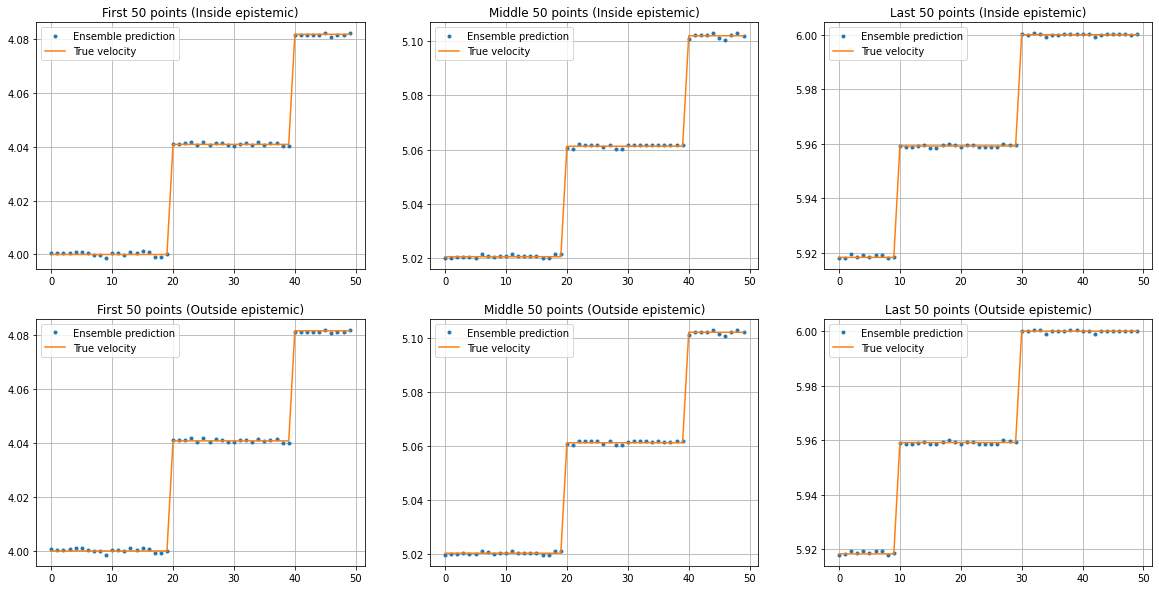

In [ ]:
mid_in = int(len(pred_target_in)/2)
mid_out = int(len(pred_target_out)/2)

figure, axis = plt.subplots(2, 3,figsize=(20, 10))
axis[0, 0].plot(all_pred_in[:50],'.',label='Ensemble prediction')
axis[0, 0].plot(pred_target_in[:50].to_numpy(), label='True velocity')
axis[0, 0].set_title("First 50 points (Inside epistemic)")
axis[0, 0].legend()
axis[0, 0].grid()

axis[0, 1].plot(all_pred_in[mid_in:(mid_in+50)],'.',label='Ensemble prediction')
axis[0, 1].plot(pred_target_in[mid_in:(mid_in+50)].to_numpy(), label='True velocity')
axis[0, 1].set_title("Middle 50 points (Inside epistemic)")
axis[0, 1].legend()
axis[0, 1].grid()

axis[0, 2].plot(all_pred_in[-50:],'.',label='Ensemble prediction')
axis[0, 2].plot(pred_target_in[-50:].to_numpy(), label='True velocity')
axis[0, 2].set_title("Last 50 points (Inside epistemic)")
axis[0, 2].legend()
axis[0, 2].grid()

axis[1, 0].plot(all_pred_out[:50],'.',label='Ensemble prediction')
axis[1, 0].plot(pred_target_out[:50].to_numpy(), label='True velocity')
axis[1, 0].set_title("First 50 points (Outside epistemic)")
axis[1, 0].legend()
axis[1, 0].grid()

axis[1, 1].plot(all_pred_out[mid_out:(mid_out+50)],'.',label='Ensemble prediction')
axis[1, 1].plot(pred_target_out[mid_out:(mid_out+50)].to_numpy(), label='True velocity')
axis[1, 1].set_title("Middle 50 points (Outside epistemic)")
axis[1, 1].legend()
axis[1, 1].grid()

axis[1, 2].plot(all_pred_out[-50:],'.',label='Ensemble prediction')
axis[1, 2].plot(pred_target_out[-50:].to_numpy(), label='True velocity')
axis[1, 2].set_title("Last 50 points (Outside epistemic)")
axis[1, 2].legend()
axis[1, 2].grid()